# Run TJPCOV with LSST Specs

TODO:
- Get the n(z) and binning of LSST from CCLX notebooks
- Get the mask of LSST
- Make the initiaiton of the sacc file
- Get the Gaussian and Namaster covariance 

Then to include CMB lensing
- Maks of CMB maps (Planck, SO and S4)
- Compute the Gaussian and the Namaster covariances

But for CMB lensing we need to include the CMB K reconstruction noise whihc depends on the experiment considered. For now I had a random constant to have teh cmbk noise in TJPCov

In [1]:
import sacc
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as pl
import healpy as hp
import pymaster as nmt
import yaml


In [2]:
ccl.__version__

'3.0.0'

In [3]:
# Set this directory according to where it is on your computer
cclx_dir = '/Users/louis/code/CCLX'

In [4]:
# Import the binning recipes of LSST DESC 

import sys, os
sys.path.append(os.path.join(cclx_dir))

import srd_redshift_distributions as srd
import binning

In [5]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 300)
forecast_years = ["1", "10"] 

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

normalised = False
for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=normalised,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=normalised,
                                                                                save_file=False)

In [6]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
normalised = False
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=normalised,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=normalised,
                                                           save_file=False)


Text(0.5, 0, 'z')

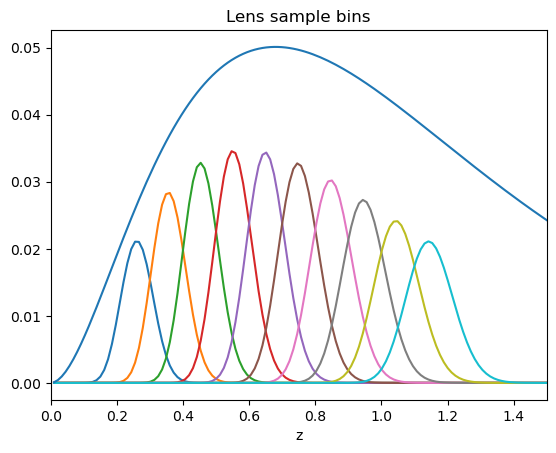

In [7]:
# plots 
year = '10' 

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    pl.plot(redshift_range,
            data, 
            label=f"Bin {key+1}",)
pl.xlim(0, 1.5)

pl.plot(redshift_range, redshift_distribution["lenses"][year] )

pl.title('Lens sample bins')
pl.xlabel('z')

Text(0.5, 0, 'z')

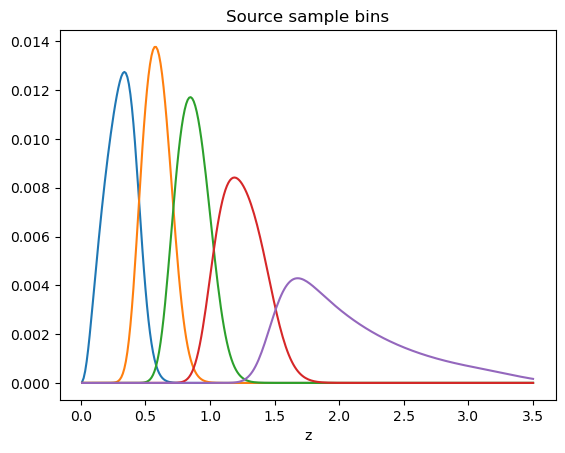

In [8]:
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    pl.plot(redshift_range,
            data, 
            label=f"Bin {key+1}",)
# pl.xlim(0, 1.5)


pl.title('Source sample bins')
pl.xlabel('z')

## Generate the data
We will first use CCL to generate some data. This will include all the auto- and cross-correlations between a redshift bin with galaxy clustering and cosmic shear, one CMB lensing map and I/Q/U maps in a given frequency channel.

In [9]:
bins["sources"][year].keys()

dict_keys([0, 1, 2, 3, 4])

In [10]:
# bpw_edges = np.array(
#         [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]
#     )

# n_ell = 20


# density, shear_E, shear_B, I, Q, U, kappa
# n_maps = 3 + 3 + 1
# density, shear_E, shear_B, kappa
# n_maps = 3 + 1

# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)

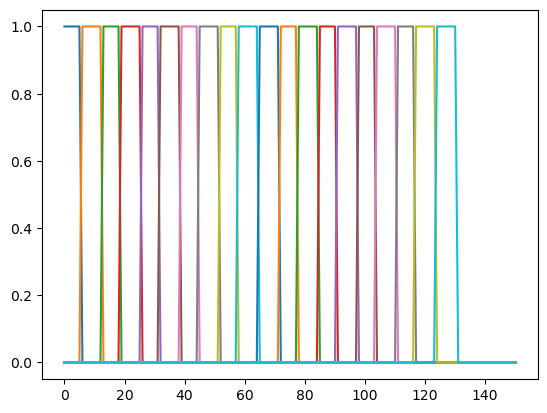

In [11]:
lmin = 20 
lmax = 150 # Becasue lmax = 3 * nside ? 
n_ell = 20 

bpw_edges = np.linspace(lmin, lmax+1, n_ell+1)
ells = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
d_ell = np.diff(bpw_edges)

ells_large = np.arange(lmax+1)
window_single = np.zeros([n_ell, lmax+1])
for i in range(n_ell):
    window_single[i, int(i * d_ell[i]) : int((i + 1) * d_ell[i])] = 1.

pl.figure()
for w in window_single:
    pl.plot(ells_large, w)
# pl.xlim([0,100])
pl.show()

### LSS power spectra
First we create the galaxy clustering (GC), weak lensing (WL) and CMB lensing tracers with CCL for which we will compute power spectra

In [12]:
import yaml

In [13]:
with open(os.path.join(cclx_dir, "parameters/lsst_desc_parameters.yaml"), "r") as f:
    lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

In [14]:
# CCL tracers

forecast_year = '10' 

galaxy_bias_prefactor = lsst_parameters['lens_sample'][forecast_year]['galaxy_bias_prefactor']
# bz = 1 + redshift_range 
# Also we negelt IA for now 
bofz = lambda z :  galaxy_bias_prefactor / cosmo.growth_factor(1/(1+z))
# bias_z = galaxy_bias_prefactor / cosmo.growth_factor(1/(1+redshift_range))
bias_z = bofz(redshift_range)
gc = {}
sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    gc[bin_idx] = ccl.NumberCountsTracer(cosmo, dndz=(redshift_range, data), bias=(redshift_range, bias_z), has_rsd=True)

for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):

    sh[bin_idx] = ccl.WeakLensingTracer(cosmo, dndz=(redshift_range, data), ia_bias=None)

ck = ccl.CMBLensingTracer(cosmo, z_source=1100.)




In [15]:
# Get gal density per bin

n_bar_lens = lsst_parameters['lens_sample'][year]['n_bar']
n_bar_source = lsst_parameters['source_sample'][year]['n_bar']

nbar_gc = {}
nbar_sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):    
    nbar_gc[bin_idx] = -np.trapz(data, redshift_range) 
norm_tot = np.sum(np.fromiter((nbar_gc[k] for k in nbar_gc.keys()), float))
for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nbar_gc[bin_idx] *= n_bar_lens / norm_tot
    
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):    
    nbar_sh[bin_idx] = -np.trapz(data, redshift_range) 

norm_tot = np.sum(np.fromiter((nbar_sh[k] for k in nbar_sh.keys()), float))
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    nbar_sh[bin_idx] *= n_bar_source / norm_tot
 

In [16]:
nbar_sh

{0: 5.47731275713034,
 1: 5.358229897891809,
 2: 5.369935339216082,
 3: 5.388981573708484,
 4: 5.405540432053287}

In [17]:
nbar_gc

{0: 2.886465455920032,
 1: 4.0850132787952695,
 2: 4.9431256824129575,
 3: 5.4497595397327325,
 4: 5.651290371610469,
 5: 5.612857216780005,
 6: 5.39979128080799,
 7: 5.069493974851079,
 8: 4.668712017623702,
 9: 4.233491181465768}

In [18]:
# Noise power spectra
nl_gc = {}
nl_sh = {}
sigma_e = 0.26

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nl_gc[bin_idx] = np.ones(n_ell) / (nbar_gc[bin_idx] * (60 * 180 / np.pi)**2)

for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):       
    nl_sh[bin_idx] = np.ones(n_ell) * sigma_e**2 / (nbar_sh[bin_idx] * (60 * 180 / np.pi)**2)


# Power spectra

[]

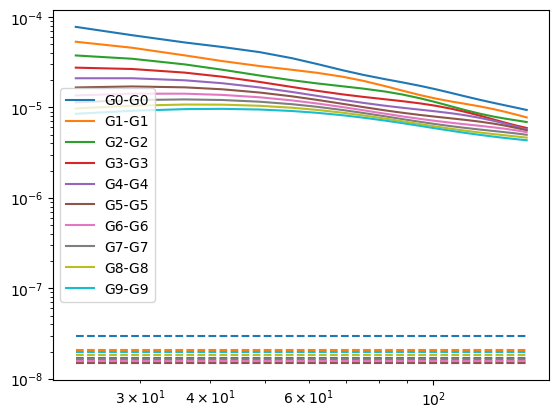

In [19]:
cls = {}

for bin_idx in bins["lenses"][year]:
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls[f'G{bin_idx}-G{bin_idx}'] = ccl.angular_cl(cosmo, gc[bin_idx], gc[bin_idx], ells)
    p = pl.plot(ells, cls[f'G{bin_idx}-G{bin_idx}'], label=f'G{bin_idx}-G{bin_idx}')
    pl.plot(ells, nl_gc[bin_idx], ls='--', c=p[0].get_color())
pl.legend()
pl.loglog()

[]

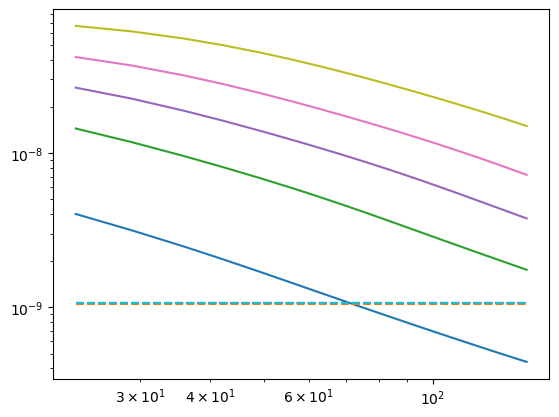

In [20]:
for bin_idx in bins["sources"][year]:
    
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls[f'W{bin_idx}-W{bin_idx}'] = ccl.angular_cl(cosmo, sh[bin_idx], sh[bin_idx], ells)
    pl.plot(ells, cls[f'W{bin_idx}-W{bin_idx}'], label=f'W{bin_idx}-W{bin_idx}')
    pl.plot(ells, nl_sh[bin_idx], ls='--')
pl.loglog()

In [21]:
# GC x WL


# Create the SACC files

In [22]:
s = sacc.Sacc()

### Tracers
Now we add all maps as individual tracers.
The GC and WL maps will be `NZ` tracers, the CMBK tracer will be a `Map` tracer.

In [23]:
# GC
for bin_idx in bins["lenses"][year]:
    s.add_tracer('NZ', f'gc{bin_idx}',  # Name
                 quantity='galaxy_density',  # Quantity
                 spin=0,  # Spin
                 z=redshift_range,  # z
                 nz=bins["lenses"][year][bin_idx])  # nz

# WL
for bin_idx in bins["sources"][year]:
    s.add_tracer('NZ', f'wl{bin_idx}',  # Name
                 quantity='galaxy_shear',  # Quantity
                 spin=2,  # Spin
                 z=redshift_range,  # z
                 nz=bins["lenses"][year][bin_idx])  # nz
#                  extra_columns={'error': 0.1*nz},  # You can include extra columns for the N(z)
#                  sigma_g=0.28)  # You can add any extra information as **kwargs

In [24]:
s.tracers

{'gc0': <sacc.tracers.NZTracer at 0x15efbdad0>,
 'gc1': <sacc.tracers.NZTracer at 0x15efa4b90>,
 'gc2': <sacc.tracers.NZTracer at 0x15f6ff250>,
 'gc3': <sacc.tracers.NZTracer at 0x15f763790>,
 'gc4': <sacc.tracers.NZTracer at 0x15f52db90>,
 'gc5': <sacc.tracers.NZTracer at 0x15f52f650>,
 'gc6': <sacc.tracers.NZTracer at 0x15f799410>,
 'gc7': <sacc.tracers.NZTracer at 0x15f798a50>,
 'gc8': <sacc.tracers.NZTracer at 0x15f798710>,
 'gc9': <sacc.tracers.NZTracer at 0x15f798250>,
 'wl0': <sacc.tracers.NZTracer at 0x15f798a10>,
 'wl1': <sacc.tracers.NZTracer at 0x15f79a3d0>,
 'wl2': <sacc.tracers.NZTracer at 0x15f79a4d0>,
 'wl3': <sacc.tracers.NZTracer at 0x15f79a590>,
 'wl4': <sacc.tracers.NZTracer at 0x15f79a690>}

In [25]:
window_single.shape

(20, 151)

In [26]:
cls[f'G{bin_idx}-G{bin_idx}'].shape

(20,)

In [27]:
ells.shape

(20,)

In [28]:
# Create a SACC bandpower window object
wins = sacc.BandpowerWindow(ells_large, window_single.T)


# GC 
for bin_idx in bins["lenses"][year]: 
    s.add_ell_cl('cl_00',  # Data type
                 f'gc{bin_idx}',  # 1st tracer's name
                 f'gc{bin_idx}',  # 2nd tracer's name
                 ells,  # Effective multipole
                 cls[f'G{bin_idx}-G{bin_idx}'],  # Power spectrum values
                 window=wins,  # Bandpower windows
                )
    
# WL
for bin_idx in bins["sources"][year]: 
    s.add_ell_cl('cl_ee', f'wl{bin_idx}', f'wl{bin_idx}', ells, cls[f'W{bin_idx}-W{bin_idx}'], window=wins)

# GC-WL
# s.add_ell_cl('cl_0e', 'gc', 'wl', ells, cls[0, 1, :], window=wins)
# s.add_ell_cl('cl_0b', 'gc', 'wl', ells, cls[0, 2, :], window=wins)


In [29]:
s.save_fits("lsstbins.fits", overwrite=True)

# Create a yaml tjpcov configuration file

In [30]:
mask_lsst = hp.read_map('mask_lsst/map_for_paul.fits')

In [31]:
fsky = np.mean(mask_lsst)
print(fsky)

0.4235026041666667


In [32]:
bin_centers = binning.Binning(redshift_range, redshift_distribution["sources"][year], year).get_bin_centers()

In [33]:
config_tjpcov_lsst = {}
config_tjpcov_lsst['tjpcov'] = {
  'sacc_file': 'lsstbins.fits',
  'cosmo': '/Users/louis/code/TJPCov/tests/data/cosmo_desy1.yaml',
#   'cov_type': 'FourierGaussianFsky',
  'cov_type': 'FourierGaussianNmt',
  'outdir': 'tmp/',
}

config_tjpcov_lsst['GaussianFsky'] = {'fsky': float(fsky)} 

config_tjpcov_lsst['tjpcov']['mask_file'] = {}
config_tjpcov_lsst['tjpcov']['mask_names'] = {}

# Get the number of galaxies per z bin
for bin_idx in bins["lenses"][year]:
    config_tjpcov_lsst['tjpcov'][f'Ngal_gc{bin_idx}'] = float(nbar_gc[bin_idx])
    config_tjpcov_lsst['tjpcov'][f'bias_gc{bin_idx}'] = float(bofz(bin_centers['lenses'][bin_idx]))
    config_tjpcov_lsst['tjpcov']['mask_file'][f'gc{bin_idx}'] = 'mask_lsst/map_for_paul.fits'
    config_tjpcov_lsst['tjpcov']['mask_names'][f'gc{bin_idx}'] = 'mask_lsst'

for bin_idx in bins["sources"][year]:    
    config_tjpcov_lsst['tjpcov'][f'Ngal_wl{bin_idx}'] = float(nbar_sh[bin_idx])
    config_tjpcov_lsst['tjpcov'][f'sigma_e_wl{bin_idx}'] = float(sigma_e)    
    config_tjpcov_lsst['tjpcov']['mask_file'][f'wl{bin_idx}'] = 'mask_lsst/map_for_paul.fits'
    config_tjpcov_lsst['tjpcov']['mask_names'][f'wl{bin_idx}'] = 'mask_lsst'


In [34]:
config_tjpcov_lsst['NaMaster'] ={
      'module': 'pymaster',
      'f':{
        'n_iter': 0,
        'lmax_sht': -1},
      'b':{
        'lmax': 90,
        'nlb': 10,},
      'w':{
        'lmax_mask': -1,
        'l_toeplitz': -1,
        'l_exact': -1,
        'dl_band': -1,
        'n_iter': 3,
        'recompute': True},
      'cw':
        {'l_toeplitz': -1,
        'l_exact': -1,
        'dl_band': -1,
        'n_iter': 3,
        'recompute': True},
}

In [35]:
fn_yaml = 'config_tjpcov_lsst.yml'

with open(fn_yaml, 'w') as outfile:
    yaml.dump(config_tjpcov_lsst, outfile, default_flow_style=False)


# Compute covariance matrix

In [36]:
from tjpcov.covariance_calculator import CovarianceCalculator

In [37]:
# Useful functions from TJPCov/tests/test_covariance_fourier_gaussian_nmt.py

def get_config(fname):
    return CovarianceIO._parse(fname)

def get_nmt_bin(nside, bpw_edges, lmax=None):
    if lmax is None: 
        lmax = 3*nside
    assert lmax< 3*nside +1
#     bpw_edges = np.array(
#         [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]
#     )
    if lmax != 3 * nside:
        # lmax + 1 because the last ell is not included
        bpw_edges = bpw_edges[bpw_edges < lmax + 1]
        bpw_edges[-1] = lmax + 1

    return nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])


In [38]:
nside = hp.get_nside(mask_lsst)

nmtbins = get_nmt_bin(nside, bpw_edges.astype('int'))
config_tjpcov_lsst["tjpcov"]["binning_info"] = nmtbins

In [39]:
# cc = CovarianceCalculator(fn_yaml)
cc = CovarianceCalculator(config_tjpcov_lsst)

In [40]:
cov = cc.get_covariance(use_coupled_noise=False)

Computing independent covariance blocks
Computing the blocks for independent workspaces
('gc0', 'gc0') ('gc0', 'gc0')
Loading saved covariance tmp/cov_gc0_gc0_gc0_gc0.npz
('wl0', 'wl0') ('wl0', 'wl0')
Loading saved covariance tmp/cov_wl0_wl0_wl0_wl0.npz
Computing the blocks for independent covariance workspaces
('gc0', 'gc0') ('wl0', 'wl0')
Loading saved covariance tmp/cov_gc0_gc0_wl0_wl0.npz
Computing the remaining blocks
('gc0', 'gc0') ('gc1', 'gc1')
Loading saved covariance tmp/cov_gc0_gc0_gc1_gc1.npz
('gc0', 'gc0') ('gc2', 'gc2')
Loading saved covariance tmp/cov_gc0_gc0_gc2_gc2.npz
('gc0', 'gc0') ('gc3', 'gc3')
Loading saved covariance tmp/cov_gc0_gc0_gc3_gc3.npz
('gc0', 'gc0') ('gc4', 'gc4')
Loading saved covariance tmp/cov_gc0_gc0_gc4_gc4.npz
('gc0', 'gc0') ('gc5', 'gc5')
Loading saved covariance tmp/cov_gc0_gc0_gc5_gc5.npz
('gc0', 'gc0') ('gc6', 'gc6')
Loading saved covariance tmp/cov_gc0_gc0_gc6_gc6.npz
('gc0', 'gc0') ('gc7', 'gc7')
Loading saved covariance tmp/cov_gc0_gc0_gc7_

/Users/louis/Code/TJPCov/tjpcov/covariance_builder.py:887: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(
/opt/miniconda3/envs/tjpcov0p4/lib/python3.11/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


('gc0', 'gc0') ('wl2', 'wl2')
Loading saved covariance tmp/cov_gc0_gc0_wl2_wl2.npz
('gc0', 'gc0') ('wl3', 'wl3')
Loading saved covariance tmp/cov_gc0_gc0_wl3_wl3.npz
('gc0', 'gc0') ('wl4', 'wl4')
Loading saved covariance tmp/cov_gc0_gc0_wl4_wl4.npz
('gc1', 'gc1') ('gc1', 'gc1')
Loading saved covariance tmp/cov_gc1_gc1_gc1_gc1.npz
('gc1', 'gc1') ('gc2', 'gc2')
Loading saved covariance tmp/cov_gc1_gc1_gc2_gc2.npz
('gc1', 'gc1') ('gc3', 'gc3')
Loading saved covariance tmp/cov_gc1_gc1_gc3_gc3.npz
('gc1', 'gc1') ('gc4', 'gc4')
Loading saved covariance tmp/cov_gc1_gc1_gc4_gc4.npz
('gc1', 'gc1') ('gc5', 'gc5')
Loading saved covariance tmp/cov_gc1_gc1_gc5_gc5.npz
('gc1', 'gc1') ('gc6', 'gc6')
Loading saved covariance tmp/cov_gc1_gc1_gc6_gc6.npz
('gc1', 'gc1') ('gc7', 'gc7')
Loading saved covariance tmp/cov_gc1_gc1_gc7_gc7.npz
('gc1', 'gc1') ('gc8', 'gc8')
Loading saved covariance tmp/cov_gc1_gc1_gc8_gc8.npz
('gc1', 'gc1') ('gc9', 'gc9')
Loading saved covariance tmp/cov_gc1_gc1_gc9_gc9.npz
('gc

In [41]:
cov.shape

(300, 300)

/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_29736/2344111848.py:1: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(np.abs(cov)))


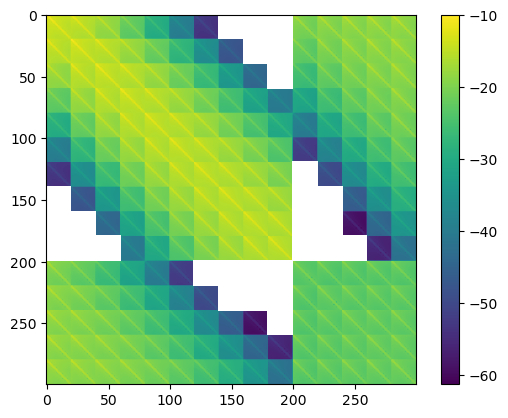

In [42]:
pl.imshow(np.log10(np.abs(cov)))
pl.colorbar()
pl.show()

In [43]:
def cov2corr(cov):
    s = np.sqrt(cov.diagonal())
    return cov/np.outer(s,s)

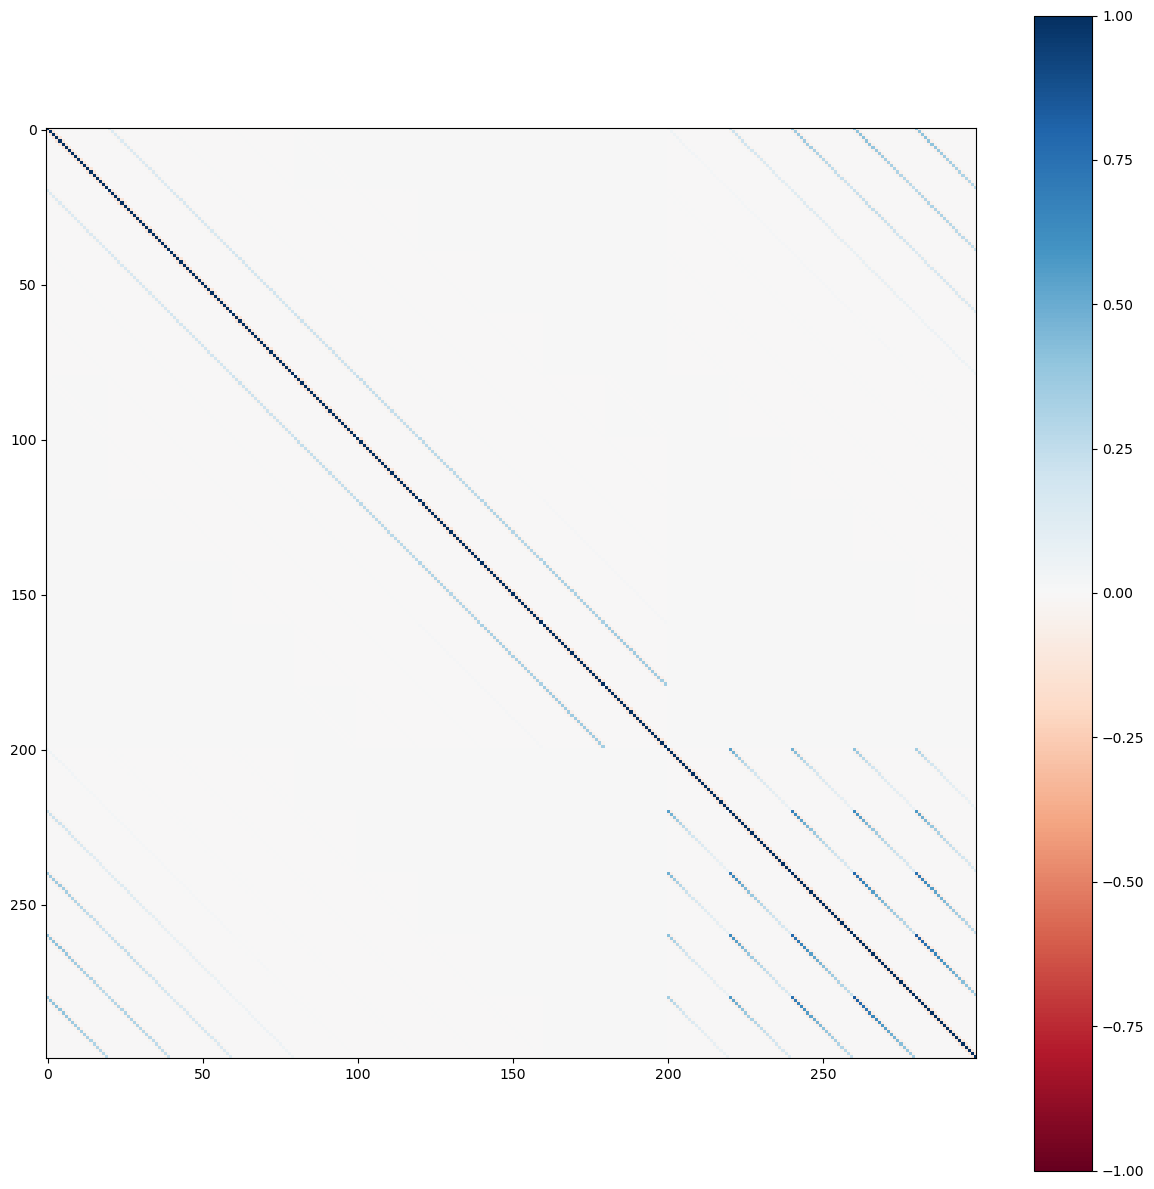

In [44]:
pl.figure(figsize=(15, 15))
pl.imshow(cov2corr(cov),vmin=-1, vmax=1, cmap='RdBu')
pl.colorbar()
pl.show()